In [1]:
#import package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.preprocessing import LabelEncoder


import AllTogether as t

import seaborn as sns

%matplotlib inline

#read dataset
results = pd.read_csv('./survey_results_public.csv')

schema = pd.read_csv('./survey_results_schema.csv')

results.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [4]:
results.columns

Index(['Respondent', 'MainBranch', 'Hobbyist', 'Age', 'Age1stCode', 'CompFreq',
       'CompTotal', 'ConvertedComp', 'Country', 'CurrencyDesc',
       'CurrencySymbol', 'DatabaseDesireNextYear', 'DatabaseWorkedWith',
       'DevType', 'EdLevel', 'Employment', 'Ethnicity', 'Gender', 'JobFactors',
       'JobSat', 'JobSeek', 'LanguageDesireNextYear', 'LanguageWorkedWith',
       'MiscTechDesireNextYear', 'MiscTechWorkedWith',
       'NEWCollabToolsDesireNextYear', 'NEWCollabToolsWorkedWith', 'NEWDevOps',
       'NEWDevOpsImpt', 'NEWEdImpt', 'NEWJobHunt', 'NEWJobHuntResearch',
       'NEWLearn', 'NEWOffTopic', 'NEWOnboardGood', 'NEWOtherComms',
       'NEWOvertime', 'NEWPurchaseResearch', 'NEWPurpleLink', 'NEWSOSites',
       'NEWStuck', 'OpSys', 'OrgSize', 'PlatformDesireNextYear',
       'PlatformWorkedWith', 'PurchaseWhat', 'Sexuality', 'SOAccount',
       'SOComm', 'SOPartFreq', 'SOVisitFreq', 'SurveyEase', 'SurveyLength',
       'Trans', 'UndergradMajor', 'WebframeDesireNextYear',
  

In [10]:
#data wrangling
#drop some descripsive columns
result=results.drop(['Respondent','CurrencyDesc','CurrencySymbol','CompTotal', 'NEWCollabToolsDesireNextYear', 'NEWCollabToolsWorkedWith', 'NEWDevOps','NEWDevOpsImpt','NEWJobHuntResearch','NEWJobHunt','NEWJobHunt','NEWPurchaseResearch','NEWPurpleLink','PlatformDesireNextYear','PlatformWorkedWith','Trans','SurveyEase','SurveyLength','WebframeDesireNextYear','WebframeWorkedWith'],axis=1)
result.shape


(64461, 42)

In [9]:
result['Sexuality'].value_counts()

Straight / Heterosexual                                  40118
Bisexual                                                  1918
Gay or Lesbian                                             978
Bisexual;Straight / Heterosexual                           258
Queer                                                      249
Bisexual;Queer                                             191
Gay or Lesbian;Queer                                        90
Straight / Heterosexual;Queer                               56
Bisexual;Gay or Lesbian                                     40
Bisexual;Gay or Lesbian;Straight / Heterosexual;Queer       39
Bisexual;Gay or Lesbian;Queer                               24
Gay or Lesbian;Straight / Heterosexual                      13
Bisexual;Straight / Heterosexual;Queer                      10
Bisexual;Gay or Lesbian;Straight / Heterosexual              8
Name: Sexuality, dtype: int64

In [11]:
result.describe()

,Age,ConvertedComp,WorkWeekHrs
count,45446.000000,3.475600e+04,41151.000000
mean,30.834111,1.037561e+05,40.782174
std,9.585392,2.268853e+05,17.816383
min,1.000000,0.000000e+00,1.000000
25%,24.000000,2.464800e+04,40.000000
50%,29.000000,5.404900e+04,40.000000
75%,35.000000,9.500000e+04,44.000000
max,279.000000,2.000000e+06,475.000000


In [14]:
#get the column names
def get_col_info(x):
    num=x.select_dtypes(include=['float','int']).columns
    cat=x.select_dtypes(include=['object']).copy().columns
    return(num,cat)


#fill the numerical NaN with mean
def fill_mean(x,num=0):
    fill_me= lambda col:col.fillna(col.mean())
    x[num]=x[num].apply(fill_me,axis=0)
    return x


#Add dummy varialbe to each the catogory
def add_dummy(x,cat=0):
    for col in  cat:
        try:
            x = pd.concat([x.drop(col, axis=1), pd.get_dummies(x[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
        except:
            continue
    return x

#process to clean data
def clean_data(x,temp):
    
    new_lists=x.dropna(subset=[temp],axis=0)
    
    y=new_lists[temp]
 
    
    X=new_lists.drop([temp],axis=1)
    [num_temp,cat_temp]=get_col_info(X)
    X=fill_mean(X,num_temp)
    X=add_dummy(X,cat_temp)
    
    return X,y

#find the coefficient
def coef_weights(coefs, X_train):   
    '''
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs']= coefs
    coefs_df['abs_coefs'] = np.abs(coefs)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

In [15]:
cutoffs = [500,400,300,400,200]

In [34]:
#Function to input dependent variable
def fit_and_coef(x,y_input):
    [X,y]=clean_data(x,y_input)
    cut_max=X.shape[1]
    if cut_max % 100 == 0:
        cut_max=cut_max
    else: 
        cut_max=cut_max + 100 - cut_max % 100
    cutoffs = [int(1.2*cut_max),int(1.0*cut_max),int(0.8*cut_max),int(0.6*cut_max),int(0.4*cut_max),int(0.2*cut_max)]
    #Run this cell to pass your X and y to the model for testing
    r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = t.find_optimal_lm_mod(X, y, cutoffs)
   
    #Get the most influent coef
    coef_df = coef_weights(lm_model.coef_, X_train)
        
    
    #A quick look at the top results
    return coef_df,r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test
    

42

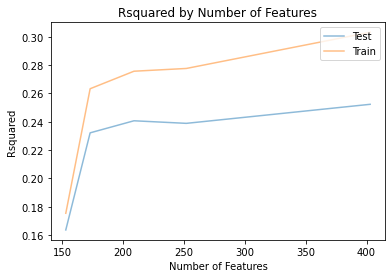

,est_int,coefs,abs_coefs
24,CompFreq_Weekly,392943.815065,392943.815065
60,Country_United States,247246.297799,247246.297799
41,Country_Ireland,224200.451601,224200.451601
47,Country_Norway,192827.731086,192827.731086
59,Country_United Kingdom,190400.601251,190400.601251
56,Country_Switzerland,181738.172220,181738.172220
25,CompFreq_Yearly,-170288.407995,170288.407995
46,Country_New Zealand,160776.152648,160776.152648
27,Country_Australia,158933.873657,158933.873657
31,Country_Canada,156407.653657,156407.653657


In [18]:
#let the dependent variable to be 'ConvertedComp'
[coef_df,r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test]=fit_and_coef(result,'ConvertedComp')
coef_df.head(20)

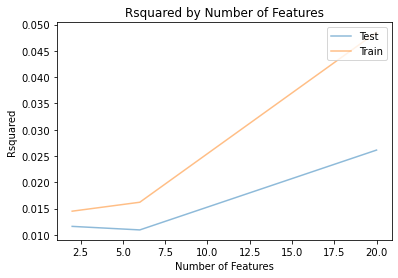

,est_int,coefs,abs_coefs
3,CompFreq_Yearly,-72689.240133,72689.240133
5,Ethnicity_White or of European descent,49108.507208,49108.507208
12,PurchaseWhat_I have little or no influence,22857.390391,22857.390391
4,"EdLevel_Bachelor’s degree (B.A., B.S., B.Eng.,...",21714.841486,21714.841486
13,PurchaseWhat_I have some influence,20388.383146,20388.383146
11,OpSys_Windows,-20286.240261,20286.240261
15,SOAccount_Yes,18683.850747,18683.850747
17,SOVisitFreq_Multiple times per day,-13747.797992,13747.797992
6,"JobSeek_I’m not actively looking, but I am ope...",-12964.323166,12964.323166
19,WelcomeChange_Just as welcome now as I felt la...,10539.600518,10539.600518


In [35]:
#compare to the dataset dropping country information
result_nocountry=result.drop(['Country'],axis=1)
result_nocountry=result_nocountry.drop(result_nocountry.tail(50000).index)
[coef_df,r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test]=fit_and_coef(result_nocountry,'ConvertedComp')
coef_df.head(20)

In [23]:
coef_df.head(20)

,est_int,coefs,abs_coefs
24,CompFreq_Weekly,392943.815065,392943.815065
60,Country_United States,247246.297799,247246.297799
41,Country_Ireland,224200.451601,224200.451601
47,Country_Norway,192827.731086,192827.731086
59,Country_United Kingdom,190400.601251,190400.601251
56,Country_Switzerland,181738.172220,181738.172220
25,CompFreq_Yearly,-170288.407995,170288.407995
46,Country_New Zealand,160776.152648,160776.152648
27,Country_Australia,158933.873657,158933.873657
31,Country_Canada,156407.653657,156407.653657


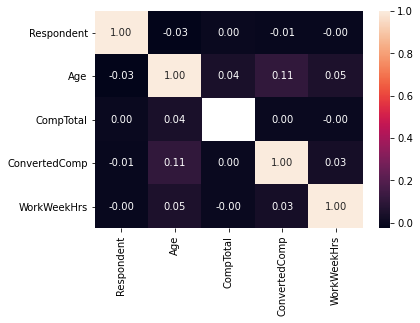

In [12]:
sns.heatmap(results.corr(), annot=True, fmt=".2f");

#lists=lists.drop([review_scores],axis=1)

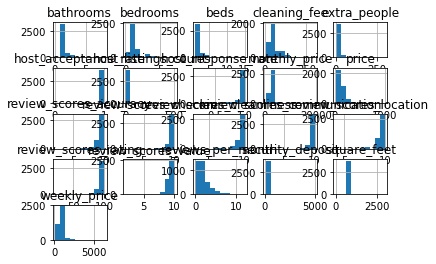

In [8]:
lists[num_cols].hist();